In [199]:
import matplotlib.pyplot as plt
import numpy as np

In [200]:
T = 0.5
step = 1

# T = 2
# step = 4

# T = 5
# step = 10

In [201]:
measurements_raw = np.loadtxt('./exam-observations-polar.csv', delimiter=',')
measurements_raw[0], measurements_raw.shape

(array([19.21055038,  1.16552458, 18.75563123,  1.67260629]), (600, 4))

In [202]:
measurements = measurements_raw[::step, :]
measurements[0], measurements.shape

(array([19.21055038,  1.16552458, 18.75563123,  1.67260629]), (600, 4))

In [203]:
track_raw = np.loadtxt('./exam-track.csv', delimiter=',')
track_raw[0], track_raw.shape

(array([8.1000e+00, 1.8900e+01, 1.5000e-02, 2.5000e-02, 5.1401e-02]), (600, 5))

In [204]:
track = track_raw[::step, :]
track[0],  track.shape

(array([8.1000e+00, 1.8900e+01, 1.5000e-02, 2.5000e-02, 5.1401e-02]), (600, 5))

In [205]:
y1 = np.array([
    [measurements[:, 0] * np.cos((measurements[:, 1]))],
    [measurements[:, 0] * np.sin((measurements[:, 1]))],
]).squeeze().T

y2 = np.array([
    [measurements[:, 2] * np.cos((measurements[:, 3]))],
    [measurements[:, 2] * np.sin((measurements[:, 3]))],
]).squeeze().T

In [206]:
sigma_v = 0.2
sigma_w = 0.001

sigma_r = 0.9

def sigma_phi(r):
    return 0.01 / np.sqrt(max(r, 1e-6))

### Kalman Filter

In [207]:
def f(x : np.ndarray) -> np.ndarray:
    w = x[-1, 0]
    
    if abs(w) < 1e-6:
        # лимит ω → 0: прямолинейное движение
        a13 = T
        a14 = 0
        a23 = 0
        a24 = T
        a33 = 1
        a34 = 0
        a43 = 0
        a44 = 1
    else:
        # обычные формулы для вращения
        a13 = np.sin(w*T) / w
        a14 = (np.cos(w*T) - 1) / w
        a23 = (1 - np.cos(w*T)) / w
        a24 = np.sin(w*T) / w
        a33 = np.cos(w*T)
        a34 = -np.sin(w*T)
        a43 = np.sin(w*T)
        a44 = np.cos(w*T)
    
    return np.array([
        [1, 0, a13, a14, 0],
        [0, 1, a23, a24, 0],
        [0, 0, a33, a34, 0],
        [0, 0, a43, a44, 0],
        [0, 0, 0, 0, 1],
    ]) @ x

In [208]:
Q = np.zeros((5, 5))
Q[0, 0] = T**3 * sigma_v**2 / 3
Q[0, 2] = T**2 * sigma_v**2 / 2
Q[1, 1] = T**3 * sigma_v**2 / 3
Q[1, 3] = T**2 * sigma_v**2 / 2
Q[2, 0] = T**2 * sigma_v**2 / 2
Q[2, 2] = T * sigma_v**2
Q[3, 1] = T**2 * sigma_v**2 / 2
Q[3, 3] = T * sigma_v**2
Q[4, 4] = T * sigma_w**2

In [209]:
def A(x : np.ndarray) -> np.ndarray:
    x1d = x[-3, 0]
    x2d = x[-2, 0]
    w = x[-1, 0]
    
    if abs(w) < 1e-6:
        a13 = T
        a14 = 0
        a15 = 0
        a23 = 0
        a24 = T
        a25 = 0
        a33 = 1
        a34 = 0
        a35 = -T * x2d
        a43 = 0
        a44 = 1
        a45 = T * x1d
    else:
        a13 = np.sin(T*w)/w
        a14 = (np.cos(T*w)-1)/w
        a15 = 1/w**2 * (x2d + (T*w*x1d - x2d)*np.cos(T*w) - (x1d + T*w*x2d)*np.sin(T*w))
        a23 = (1-np.cos(T*w))/w
        a24 = np.sin(T*w)/w
        a25 = 1/w**2 * (-x1d + (x1d + T*w*x2d)*np.cos(T*w) + (T*w*x1d - x2d)*np.sin(T*w))
        a33 = np.cos(T*w)
        a34 = -np.sin(T*w)
        a35 = -T*(x2d*np.cos(T*w) + x1d*np.sin(T*w))
        a43 = np.sin(T*w)
        a44 = np.cos(T*w)
        a45 = T*(x1d*np.cos(T*w) - x2d*np.sin(T*w))
        
    return np.array([
        [1, 0, a13, a14, a15],
        [0, 1, a23, a24, a25],
        [0, 0, a33, a34, a35],
        [0, 0, a43, a44, a45],
        [0, 0, 0, 0, 1],
    ])

In [210]:
def h(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    
    return np.array([
        [np.sqrt(x1**2 + x2**2)],
        [np.arctan2(x2, x1)],
        [np.sqrt((x1-10)**2 + x2**2)],
        [np.arctan2(x2, (x1-10))],
    ])

In [211]:
# import sympy as sp

# x1, x2 = sp.symbols('x1, x2')

# r = sp.sqrt((x1-10)**2 + x2**2)
# phi = sp.atan2(x2, (x1-10))
# sp.diff(phi, x2)

In [ ]:
def H(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    
    square_sum1 = x1**2 + x2**2
    square_sum2 = (x1-10)**2 + x2**2
    
    return np.array([
        [x1 / np.sqrt(square_sum1), x2 / np.sqrt(square_sum1), 0, 0, 0],
        [-x2 / square_sum1, x1 / square_sum1, 0, 0, 0],
        [(x1-10) / np.sqrt(square_sum2), x2 / np.sqrt(square_sum2), 0, 0, 0],
        [-x2 / square_sum2, (x1-10) / square_sum2, 0, 0, 0],
    ])

In [213]:
def normalize_angle(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))

In [214]:
def kalman_filter(x0, P0, Q):

    x = x0.copy()
    P = P0.copy()

    xarr = [x0]
    Parr = [P0]

    for measurement in measurements:
        x_est = f(x)
        P_est = A(x) @ P @ A(x).T + Q
        
        y = measurement.reshape(-1, 1)
        y_est = h(x_est)
        
        dy = y - y_est
        dy[1,0] = normalize_angle(dy[1, 0])
        dy[3,0] = normalize_angle(dy[3, 0])
        
        r1 = y[0, 0]
        r2 = y[2, 0]
        
        R = np.array([
            [sigma_r**2, 0, 0, 0],
            [0, sigma_phi(r1)**2, 0, 0],
            [0, 0, sigma_r**2, 0],
            [0, 0, 0, sigma_phi(r2)**2]
        ])
        
        S = H(x_est) @ P_est @ H(x_est).T + R
        F = P_est @ H(x_est).T @ np.linalg.inv(S)
        
        x = x_est + F @ dy
        P = (np.eye(x0.shape[0]) - F @ H(x_est)) @ P_est
        
        xarr.append(x)
        Parr.append(P)  
        
    xarr = np.array(xarr).squeeze()
    Parr = np.array(Parr).squeeze()
    return xarr, Parr

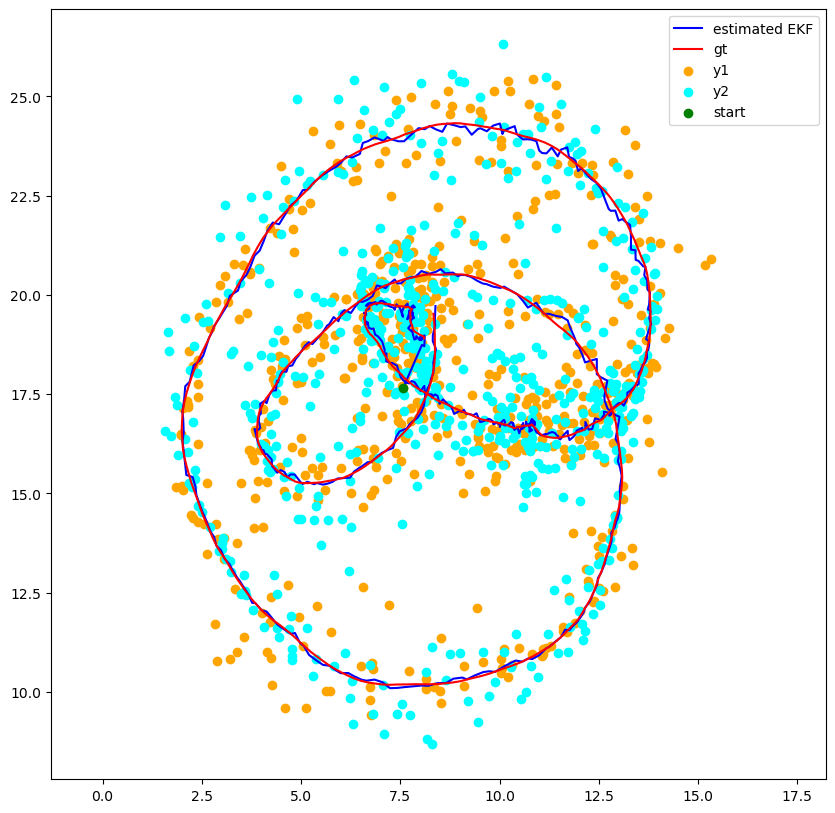

In [215]:
x0 = np.hstack([y1[0, 0], y1[0, 1], 0.02, 0.02, 0.02]).reshape(-1, 1)
P0 = np.eye(x0.shape[0]) * 100

xarr, Parr = kalman_filter(x0, P0, Q)

plt.figure(figsize=(10, 10))

plt.plot(xarr[:, 0], xarr[:, 1], color='b', label='estimated EKF')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')
plt.scatter(y1[:, 0], y1[:, 1], color='orange', label='y1')
plt.scatter(y2[:, 0] + 10, y2[:, 1], color='cyan', label='y2')
plt.scatter(y1[0, 0], y1[0, 1], color='g', label='start', zorder=2)

plt.axis('equal')
plt.legend()
plt.savefig(f'ekf_T_{T}.png', dpi=300)
plt.show()

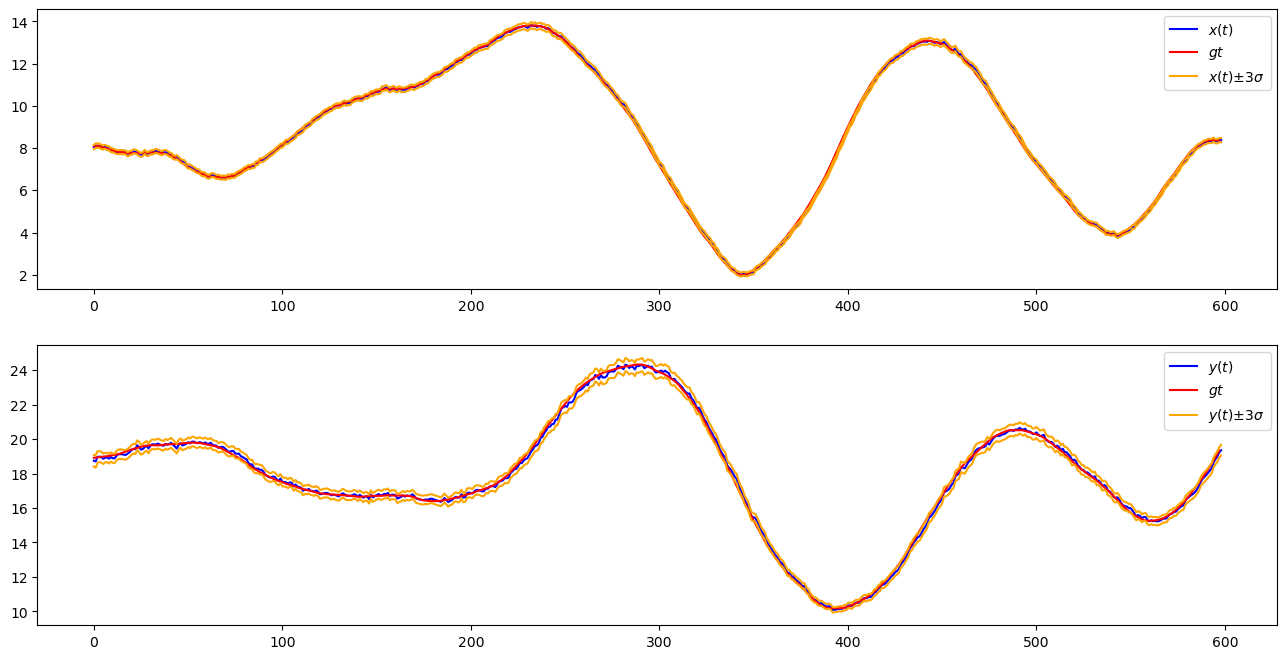

In [216]:
end = -1

_, (ax, ay) = plt.subplots(2, 1, figsize=(16, 8))

ax.plot(xarr[1:end, 0], color='b', label=r'$x(t)$')
ax.plot(track[1:end, 0], color='r', label=r'$gt$')
ax.plot(xarr[1:end, 0]+3*np.sqrt(Parr[1:end, 0, 0]), color='orange', label=r'$x(t)$±3$\sigma$')
ax.plot(xarr[1:end, 0]-3*np.sqrt(Parr[1:end, 0, 0]), color='orange')
ax.legend()

ay.plot(xarr[1:end, 1], color='b', label=r'$y(t)$')
ay.plot(track[1:end, 1], color='r', label=r'$gt$')
ay.plot(xarr[1:end, 1]+3*np.sqrt(Parr[1:end, 1, 1]), color='orange', label=r'$y(t)$±3$\sigma$')
ay.plot(xarr[1:end, 1]-3*np.sqrt(Parr[1:end, 1, 1]), color='orange')
ay.legend()

plt.savefig(f'ekf_plots_T_{T}.png', dpi=300)
plt.show()

### Particle Filter

In [217]:
def normal_distribution(x, mean, std):
    return 1/std/np.sqrt(2*np.pi) * np.exp(-(x - mean)**2 / 2 / std**2)

In [218]:
def initialize_particles(num_particles, x1_mean, x2_mean, x_std, v_mean, v_std, w_mean, w_std):
    particles = []
    for _ in range(num_particles):
        particle = dict()
        particle['x1'] = np.random.normal(x1_mean, x_std)
        particle['x2'] = np.random.normal(x2_mean, x_std)
        particle['v1'] = np.random.normal(v_mean, v_std)
        particle['v2'] = np.random.normal(v_mean, v_std)
        particle['w'] = np.random.normal(w_mean, w_std)
        particles.append(particle)
    return particles


In [219]:
def sample_motion_model(particles, T, sigma_v, sigma_w):
    new_particles = []

    for p in particles:
        x1 = p['x1']
        x2 = p['x2']
        v1 = p['v1']
        v2 = p['v2']
        w = p['w']

        v1_noisy = v1 + np.random.normal(0, sigma_v)
        v2_noisy = v2 + np.random.normal(0, sigma_v)
        w_noisy = w + np.random.normal(0, sigma_w)

        if abs(w_noisy) < 1e-6:
            x1_new = x1 + v1_noisy * T
            x2_new = x2 + v2_noisy * T
        else:
            x1_new = x1 + (v1_noisy * np.sin(w_noisy*T) + v2_noisy * (1 - np.cos(w_noisy*T))) / w_noisy
            x2_new = x2 + (v2_noisy * np.sin(w_noisy*T) + v1_noisy * (np.cos(w_noisy*T) - 1)) / w_noisy

        new_particle = {
            'x1': x1_new,
            'x2': x2_new,
            'v1': v1_noisy,
            'v2': v2_noisy,
            'w': w_noisy,
        }

        new_particles.append(new_particle)

    return new_particles


In [ ]:
def eval_sensor_model(y, particles, sigma_r):
    y = y.reshape(-1, 1)

    r1 = y[0, 0]
    r2 = y[2, 0]
    sigma_phi1 = max(sigma_phi(r1), 1e-2)
    sigma_phi2 = max(sigma_phi(r2), 1e-2)

    R = np.diag([sigma_r**2, sigma_phi1**2, sigma_r**2, sigma_phi2**2])
    R_inv = np.linalg.inv(R)
    det_R = np.linalg.det(R)
    dim = y.shape[0]

    norm_const = 1.0 / np.sqrt((2 * np.pi)**dim * det_R)

    likelihoods = []
    for p in particles:
        x = np.array([p['x1'], p['x2']]).reshape(-1, 1)
        y_est = h(x)

        dy = y - y_est
        dy[1, 0] = normalize_angle(dy[1, 0])
        dy[3, 0] = normalize_angle(dy[3, 0])

        exponent = -0.5 * float(dy.T @ R_inv @ dy)
        likelihood = norm_const * np.exp(exponent)
        likelihoods.append(likelihood)

    weights = np.array(likelihoods)
    return weights / weights.sum()

In [221]:
def resample_particles(particles, weights):
    new_particles = []

    step = 1 / len(weights)
    r = np.random.uniform(0, step)

    uarr = [r + i * step for i in range(len(weights))]

    cumsum = 0.0
    i = 0
    n = len(weights)

    for u in uarr:
        while u > cumsum and i < n:
           cumsum += weights[i]
           i += 1
        idx = max(i-1, 0)
        new_particles.append(particles[idx])

    return new_particles

In [222]:
def mean_cov_pose(particles):
    xs = np.array([[p['x1'], p['x2']] for p in particles])
    
    mean = np.mean(xs, axis=0)
    
    cov = np.cov(xs.T)
    
    return mean, cov

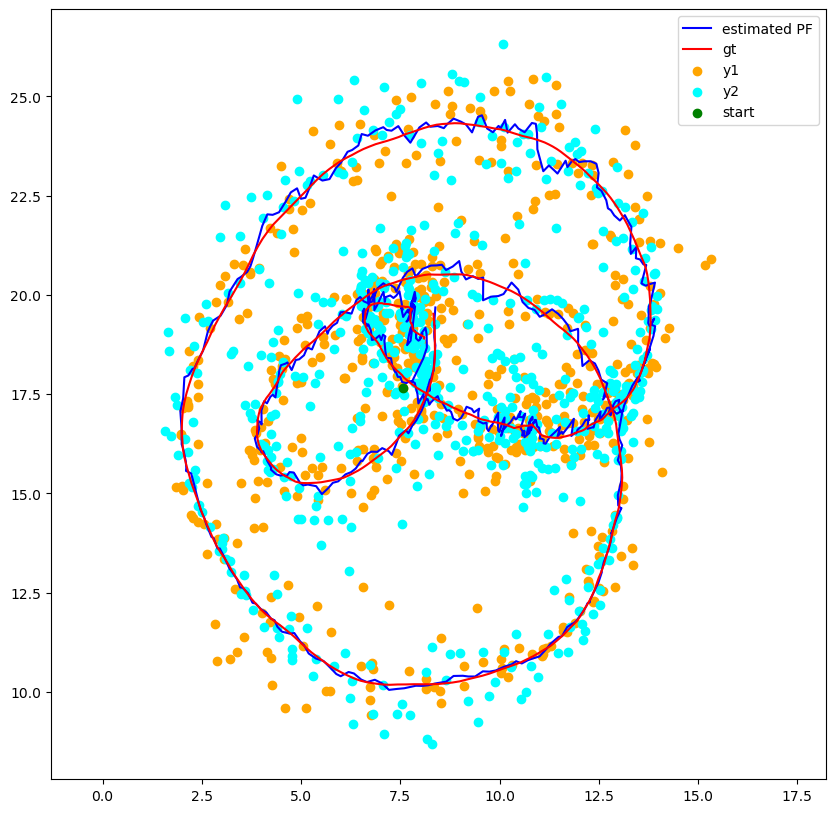

In [223]:
particles = initialize_particles(100, y1[0, 0], y1[0, 1], 1, 0.2, sigma_v, 0.2, sigma_w)

mean, cov = mean_cov_pose(particles)
mean_arr = [mean]
cov_arr = [cov]

for measurement in measurements:
    new_particles = sample_motion_model(particles, T, sigma_v, sigma_w)

    weights = eval_sensor_model(measurement, new_particles, sigma_r)
    
    particles = resample_particles(new_particles, weights)
    
    mean, cov = mean_cov_pose(particles)
    mean_arr.append(mean)
    cov_arr.append(cov)
    
mean_arr = np.array(mean_arr)
cov_arr = np.array(cov_arr)

plt.figure(figsize=(10, 10))

plt.plot(mean_arr[:, 0], mean_arr[:, 1], color='b', label='estimated PF')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')
plt.scatter(y1[:, 0], y1[:, 1], color='orange', label='y1')
plt.scatter(y2[:, 0] + 10, y2[:, 1], color='cyan', label='y2')
plt.scatter(y1[0, 0], y1[0, 1], color='g', label='start', zorder=2)

plt.legend()
plt.axis('equal')
plt.savefig(f'pf_T_{T}.png', dpi=300)
plt.show()

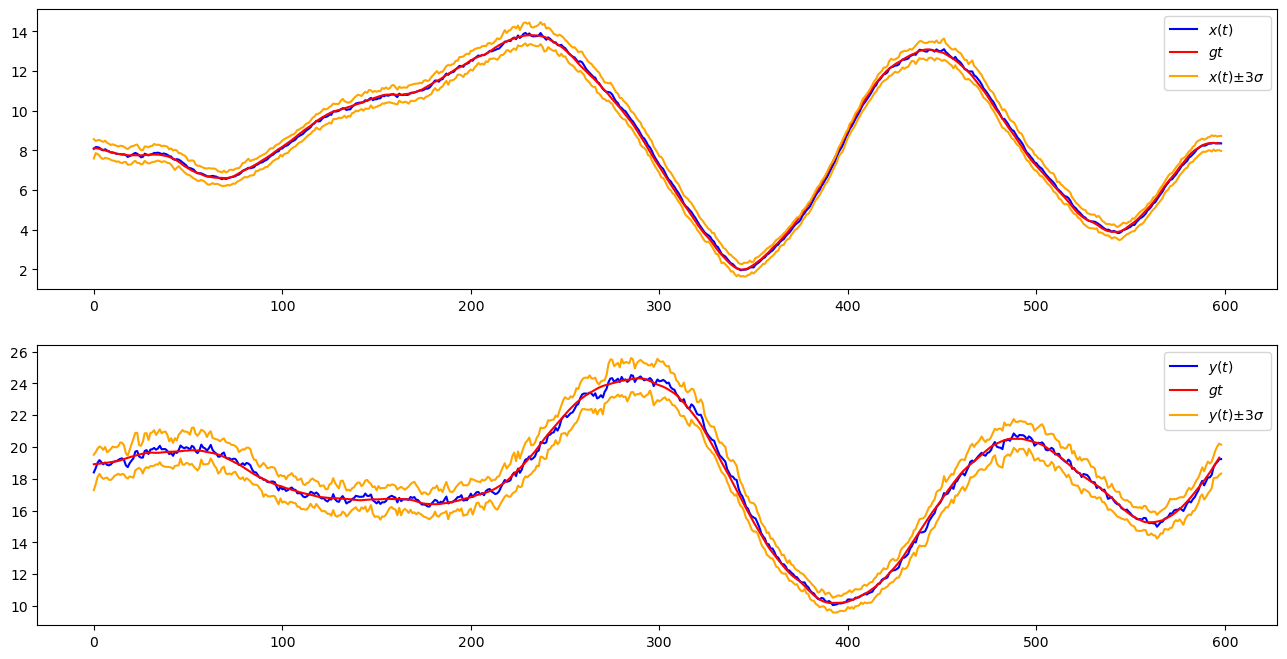

In [224]:
end = -1

_, (ax, ay) = plt.subplots(2, 1, figsize=(16, 8))

ax.plot(mean_arr[1:end, 0], color='b', label=r'$x(t)$')
ax.plot(track[1:end, 0], color='r', label=r'$gt$')
ax.plot(mean_arr[1:end, 0]+3*np.sqrt(cov_arr[1:end, 0, 0]), color='orange', label=r'$x(t)$±3$\sigma$')
ax.plot(mean_arr[1:end, 0]-3*np.sqrt(cov_arr[1:end, 0, 0]), color='orange')
ax.legend()

ay.plot(mean_arr[1:end, 1], color='b', label=r'$y(t)$')
ay.plot(track[1:end, 1], color='r', label=r'$gt$')
ay.plot(mean_arr[1:end, 1]+3*np.sqrt(cov_arr[1:end, 1, 1]), color='orange', label=r'$y(t)$±3$\sigma$')
ay.plot(mean_arr[1:end, 1]-3*np.sqrt(cov_arr[1:end, 1, 1]), color='orange')
ay.legend()

plt.savefig(f'pf_plots_T_{T}.png', dpi=300)
plt.show()

### Comparison

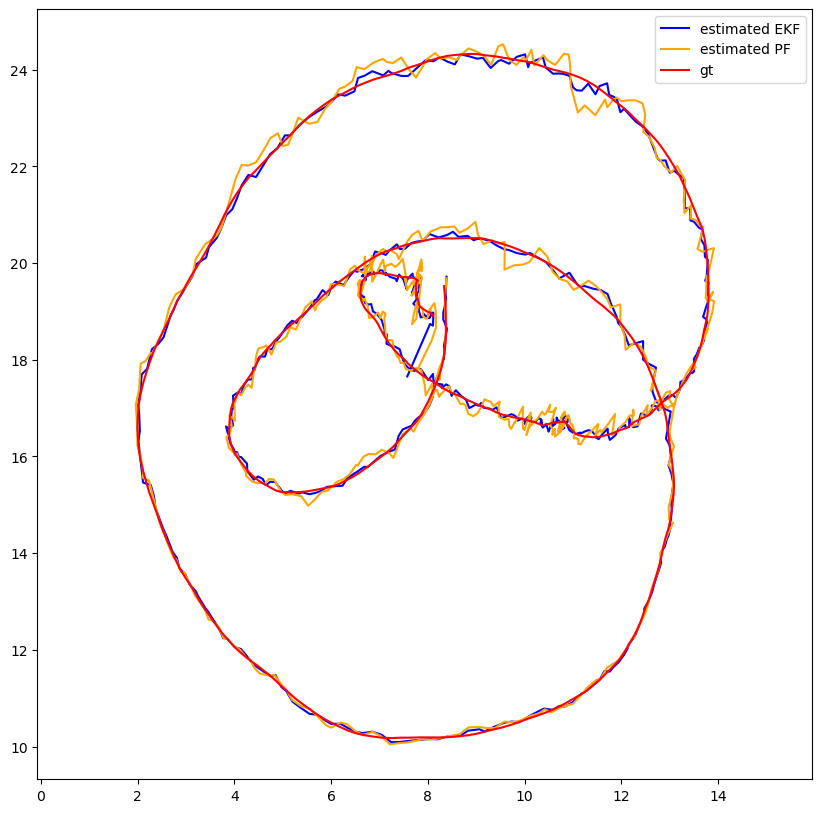

In [225]:
plt.figure(figsize=(10, 10))

plt.plot(xarr[:, 0], xarr[:, 1], color='b', label='estimated EKF')
plt.plot(mean_arr[:, 0], mean_arr[:, 1], color='orange', label='estimated PF')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')

plt.axis('equal')
plt.legend()
plt.savefig(f'comp_T_{T}.png', dpi=300)
plt.show()

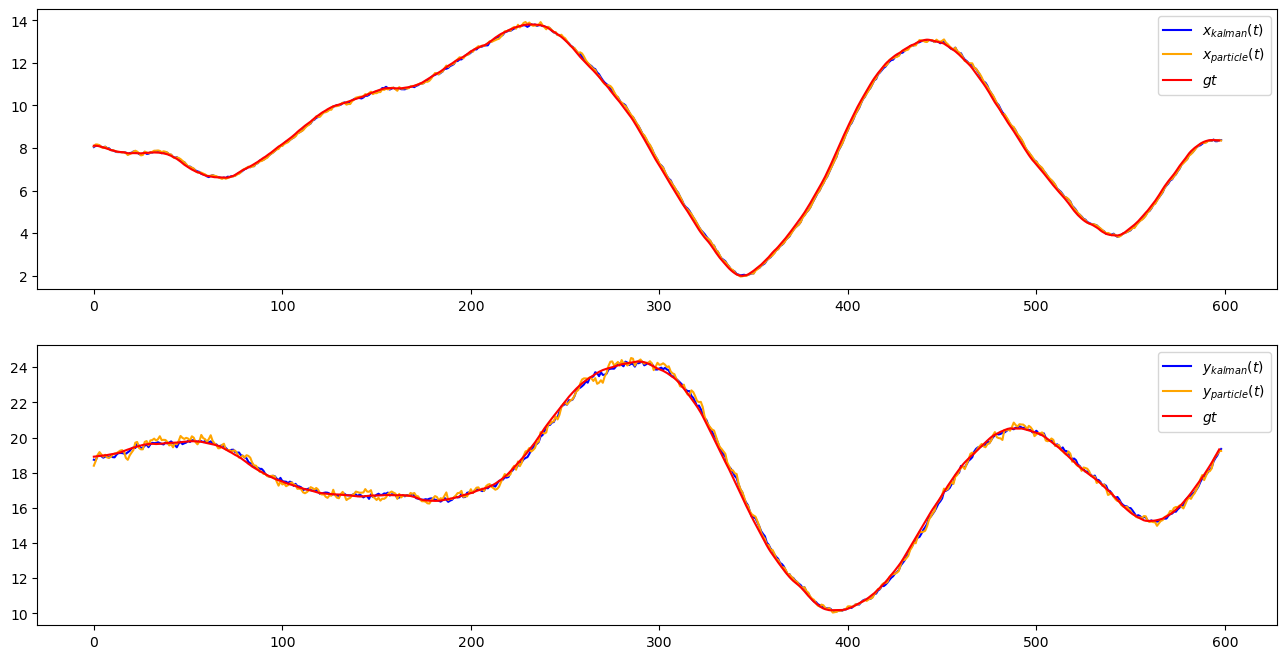

In [228]:
end = -1

_, (ax, ay) = plt.subplots(2, 1, figsize=(16, 8))

ax.plot(xarr[1:end, 0], color='b', label=r'$x_{kalman}(t)$')
ax.plot(mean_arr[1:end, 0], color='orange', label=r'$x_{particle}(t)$')
ax.plot(track[1:end, 0], color='r', label=r'$gt$')
ax.legend()

ay.plot(xarr[1:end, 1], color='b', label=r'$y_{kalman}(t)$')
ay.plot(mean_arr[1:end, 1], color='orange', label=r'$y_{particle}(t)$')
ay.plot(track[1:end, 1], color='r', label=r'$gt$')
ay.legend()

plt.savefig(f'comp_plots_T_{T}.png', dpi=300)
plt.show()